# Inverse Reinforcement Learning

Aims to learn the reward $r$ that demonstrations $\xi_{i}$ were trying to maximise. 

## Assumptions:
Can calculate feature vector $f(s)\in\mathbb{R}^{k}$ for states $s$. Examples: distance from goal, distance from box, is a box in a corner, etc.

Reward is a linear combination of $f(s)$, i.e. 
  
$$r = \theta^{T}f(s)$$ 
  
for weight vector $\theta\in\mathbb{R}^{k}$.

Maximum Entropy behaviour: 
  
$$
P(\xi_{i}|\theta) = \frac{1}{Z}\exp\{\theta^{T}f(\xi_{i})\}.
$$

## Objective:
Maximise the log-likelihood $L$ is given by
$$
L(\theta) = \sum_{\xi\,\in\,\textrm{examples}}\log P\,(\xi\,|\,\theta).
$$
  
  
We can do this by gradient descent; it turns out that:
  
  
$$
\nabla L\,(\theta) = \tilde{f} - \sum_{s_{i}}D_{s_{i}}\,f_{s_{i}}
$$
  
  
where $D_{s_{i}}$ is the expected frequency with which the agent will visit $s_{i}$. Calculating this requires solving an MDP at each gradient descent step.

In [37]:
from __future__ import print_function
import itertools
import numpy as np
import sys
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import datetime

if "../../" not in sys.path:
  sys.path.append("../../")

from ai_safety_gridworlds.environments.side_effects_sokoban import SideEffectsSokobanEnvironment as sokoban_game
import side_grids_camp.feature_extractors as fe
import side_grids_camp.IRL as irl
%matplotlib inline
from IPython.display import HTML
from side_grids_camp.utils import plot_images_to_ani, gen_images
import side_grids_camp.utils.irl_utils as utils
from ai_safety_gridworlds.demonstrations import demonstrations

In [38]:
# Set up env and demonstration trajectories:
env = sokoban_game(level=0)
board_state_map, state_board_map = utils.compute_maps()

demos = demonstrations.get_demonstrations('side_effects_sokoban')
board_mapper = utils.get_state_from_grayscale
trajectories = irl.make_trajectories(demos, env, board_mapper, board_state_map)

trajectories = np.transpose(trajectories, (0,2,1))

### Demonstrations

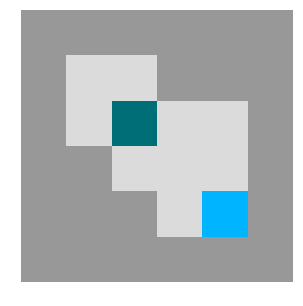

In [39]:
d_acts = []
for demo in demos:
    d_acts.append([a.value for a in demo.actions])

HTML(plot_images_to_ani(gen_images(d_acts[0], sokoban_game(level=0))).to_jshtml())

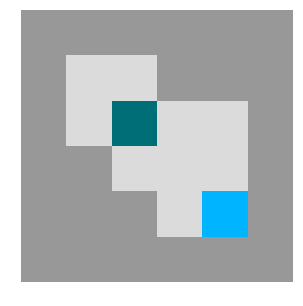

In [40]:
HTML(plot_images_to_ani(gen_images(d_acts[1], sokoban_game(level=0))).to_jshtml())

### FEATURES: distance from goal, is box in a corner

In [41]:
# features, transition probs and feature matrix
agent = 134
box = 78
goal = 129
wall = 152

# features = [fe.ObjectDistances([[agent, goal],[agent, box]]),
#             fe.IsCornered(wall, box)]
# features = [fe.Reshaper(6,6),]
features = [fe.ObjectDistances([[agent, goal]]), fe.IsCornered(wall, box)]

transition_probabilities, feature_matrix = utils.get_state_probs(state_board_map,
                                                                 board_state_map,
                                                                 features)

In [42]:
learning_rate = 1e-1
n_epochs = 100
horizon = 1
discount = 1

n_states, n_actions, _ = transition_probabilities.shape
_, n_features = feature_matrix.shape
states = np.arange(0, n_states)

#weight_init = 0.1*np.random.normal(size=(n_features))
weight_init = np.zeros(shape=(n_features))
print(weight_init)

rewards, IRL_weights = irl.maxEntIRL(states, 
                                     feature_matrix, 
                                     transition_probabilities,
                                     trajectories,
                                     learning_rate,
                                     n_epochs,
                                     horizon=horizon,
                                     discount=discount,
                                     weight_init=weight_init)

feature_expectations = irl.getFeatureExpectations(feature_matrix, trajectories)
print(IRL_weights)

[ 0.  0.  0.]
[-20.  -13.1 -29.7]


In [43]:
# %% Animate policy
policy = irl.getPolicy(transition_probabilities, rewards)
from side_grids_camp.utils.irl_utils import pl_box_coords, get_game_at, get_st


In [44]:
from side_grids_camp.utils import policy_rollout

def _policy_f(time_step):
    return policy[get_st(time_step, board_state_map), :].argmax()

def _reward_f(time_step):
    return sum(feature_matrix[get_st(time_step, board_state_map), :] * IRL_weights)

def _state_f(time_step):
    return get_st(time_step, board_state_map)

sts, acts, ep_r = policy_rollout(sokoban_game(level=0), _policy_f, _state_f, _reward_f)


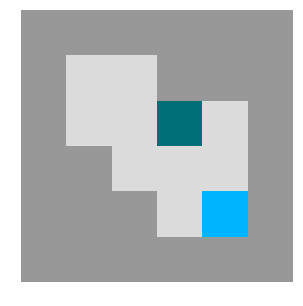

In [45]:
HTML(plot_images_to_ani(gen_images(acts, sokoban_game(level=0))).to_jshtml())

In [46]:
from ai_safety_gridworlds.environments.shared.safety_game import Actions

for act in acts:
  print(str(Actions(act)).split('.')[1], end=" ")

LEFT DOWN RIGHT DOWN RIGHT DOWN RIGHT 

In [47]:
ep_r

[-99.300000000000054,
 -79.30000000000004,
 -66.200000000000031,
 -46.200000000000031,
 -33.100000000000016,
 -13.10000000000001,
 0.0]

### FEATURES: distance from goal, is box in a corner, distance from box

In [48]:
features = [fe.ObjectDistances([[agent, goal],[agent, box]]), fe.IsCornered(wall, box)]

transition_probabilities, feature_matrix = utils.get_state_probs(state_board_map,
                                                                 board_state_map,
                                                                 features)
n_states, n_actions, _ = transition_probabilities.shape
_, n_features = feature_matrix.shape
states = np.arange(0, n_states)

#weight_init = 0.1*np.random.normal(size=(n_features))
weight_init = np.zeros(shape=(n_features))
print(weight_init)

rewards, IRL_weights = irl.maxEntIRL(states, 
                                     feature_matrix, 
                                     transition_probabilities,
                                     trajectories,
                                     learning_rate,
                                     n_epochs,
                                     horizon=horizon,
                                     discount=discount,
                                     weight_init=weight_init)

feature_expectations = irl.getFeatureExpectations(feature_matrix, trajectories)
print(IRL_weights)
policy = irl.getPolicy(transition_probabilities, rewards)

[ 0.  0.  0.  0.  0.]
[-3.2 -4.2 -3.   2.7 -8.8]


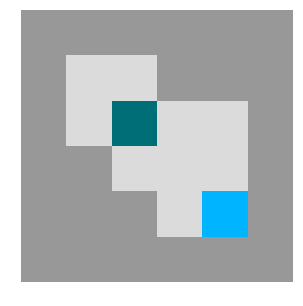

In [49]:
sts, acts, ep_r = policy_rollout(sokoban_game(level=0), _policy_f, _state_f, _reward_f)
HTML(plot_images_to_ani(gen_images(acts, sokoban_game(level=0))).to_jshtml())

In [50]:
from ai_safety_gridworlds.environments.shared.safety_game import Actions

for act in acts:
  print(str(Actions(act)).split('.')[1], end=" ")

LEFT DOWN RIGHT DOWN RIGHT RIGHT UP LEFT RIGHT DOWN DOWN 

In [51]:
ep_r

[-22.499999999999979,
 -16.299999999999976,
 -12.099999999999978,
 -11.89999999999999,
 -10.399999999999995,
 -3.5000000000000022,
 -3.6999999999999917,
 -7.8999999999999861,
 -0.99999999999999112,
 -0.8000000000000016,
 -0.60000000000001119]

### FEATURES: distance from goal, distance from box

In [52]:
features = [fe.ObjectDistances([[agent, goal],[agent, box]])]

transition_probabilities, feature_matrix = utils.get_state_probs(state_board_map,
                                                                 board_state_map,
                                                                 features)
n_states, n_actions, _ = transition_probabilities.shape
_, n_features = feature_matrix.shape
states = np.arange(0, n_states)

#weight_init = 0.1*np.random.normal(size=(n_features))
weight_init = np.zeros(shape=(n_features))
print(weight_init)

rewards, IRL_weights = irl.maxEntIRL(states, 
                                     feature_matrix, 
                                     transition_probabilities,
                                     trajectories,
                                     learning_rate,
                                     n_epochs,
                                     horizon=horizon,
                                     discount=discount,
                                     weight_init=weight_init)

feature_expectations = irl.getFeatureExpectations(feature_matrix, trajectories)
print(IRL_weights)
policy = irl.getPolicy(transition_probabilities, rewards)

[ 0.  0.  0.  0.]
[-0.6 -1.7 -0.3  0.3]


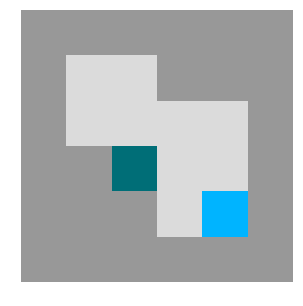

In [53]:
sts, acts, ep_r = policy_rollout(sokoban_game(level=0), _policy_f, _state_f, _reward_f)
HTML(plot_images_to_ani(gen_images(acts, sokoban_game(level=0))).to_jshtml())

In [54]:
from ai_safety_gridworlds.environments.shared.safety_game import Actions

for act in acts:
  print(str(Actions(act)).split('.')[1], end=" ")

DOWN RIGHT RIGHT DOWN DOWN 

In [55]:
ep_r

[-4.9000000000000057,
 -2.9000000000000057,
 -0.90000000000000524,
 -2.4424906541753444e-15,
 0.3000000000000016]